## NIFTY-FIFTY Stock Price Prediction using LSTM

Importing Libraries

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import math
from datetime import date
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam,Adagrad,Adamax,Nadam
from yahoo_fin.stock_info import get_data
import kerastuner as kt

C:\Users\Home\AppData\Local\Temp/ipykernel_5384/3778081498.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Importing Data

In [2]:
this_day = date.today()
today = this_day.strftime("%d/%m/%Y")
data = get_data("^NSEI", start_date="01/07/2018", end_date=today, index_as_date = True)

data['Date'] = pd.to_datetime(data.index, errors='coerce')
data.head()

,open,high,low,close,adjclose,volume,ticker,Date
2018-01-08,10591.700195,10631.200195,10588.549805,10623.599609,10623.599609,169000.0,^NSEI,2018-01-08
2018-01-09,10645.099609,10659.150391,10603.599609,10637.000000,10637.000000,205000.0,^NSEI,2018-01-09
2018-01-10,10652.049805,10655.500000,10592.700195,10632.200195,10632.200195,176400.0,^NSEI,2018-01-10
2018-01-11,10637.049805,10664.599609,10612.349609,10651.200195,10651.200195,153800.0,^NSEI,2018-01-11
2018-01-12,10682.549805,10690.400391,10597.099609,10681.250000,10681.250000,175200.0,^NSEI,2018-01-12


In [3]:
data.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker', 'Date'], dtype='object')

In [4]:
data.isnull().sum()

open        3
high        3
low         3
close       3
adjclose    3
volume      3
ticker      0
Date        0
dtype: int64

In [5]:
data = data.dropna()

Reseting the Indexes

In [6]:
dataframe = data.reset_index()['close']
dataframe.shape

(1370,)

Scaling The Data

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(dataframe).reshape(-1, 1))
df.shape

(1370, 1)

Dividing the Data Into Training And Testing 

In [8]:
training_size=int(len(df)*0.70)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]
train_data.shape, test_data.shape

((958, 1), (412, 1))

Creating a function to make Input Training and Output Training Splits

In [9]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [10]:
timestep = 30
X_train, y_train = create_dataset(dataset=train_data, time_step=timestep)
X_test, y_test = create_dataset(dataset=test_data, time_step=timestep)
X_train.shape, y_test.shape

((927, 30), (381,))

In [11]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train.shape, y_test.shape

((927, 30, 1), (381,))

### Model Building

Giving Model Parameters

In [12]:
model = Sequential([
    layers.Input((30, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='linear'),
    layers.Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), metrics=['mean_squared_error', 'accuracy'], loss='mse')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19,649
Trainable params: 19,649
Non-trainable params: 0
_________________________________________________________________


Model Fitting

In [14]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=10, verbose=1)

Epoch 1/200
93/93 [==============================] - 6s 21ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - accuracy: 0.0011 - val_loss: 5.0450e-04 - val_mean_squared_error: 5.0450e-04 - val_accuracy: 0.0026
Epoch 2/200
93/93 [==============================] - 1s 12ms/step - loss: 3.4878e-04 - mean_squared_error: 3.4878e-04 - accuracy: 0.0011 - val_loss: 4.6500e-04 - val_mean_squared_error: 4.6500e-04 - val_accuracy: 0.0026
Epoch 3/200
93/93 [==============================] - 1s 12ms/step - loss: 4.8641e-04 - mean_squared_error: 4.8641e-04 - accuracy: 0.0011 - val_loss: 3.9711e-04 - val_mean_squared_error: 3.9711e-04 - val_accuracy: 0.0026
Epoch 4/200
93/93 [==============================] - 1s 13ms/step - loss: 4.3055e-04 - mean_squared_error: 4.3055e-04 - accuracy: 0.0011 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_accuracy: 0.0026
Epoch 5/200
93/93 [==============================] - 1s 13ms/step - loss: 4.8193e-04 - mean_squared_error: 4.8193e-04 - accuracy: 0.0011

93/93 [==============================] - 1s 12ms/step - loss: 4.7557e-04 - mean_squared_error: 4.7557e-04 - accuracy: 0.0011 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_accuracy: 0.0026
Epoch 39/200
93/93 [==============================] - 1s 12ms/step - loss: 4.7783e-04 - mean_squared_error: 4.7783e-04 - accuracy: 0.0011 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_accuracy: 0.0026
Epoch 40/200
93/93 [==============================] - 1s 12ms/step - loss: 2.6010e-04 - mean_squared_error: 2.6010e-04 - accuracy: 0.0011 - val_loss: 4.8414e-04 - val_mean_squared_error: 4.8414e-04 - val_accuracy: 0.0026
Epoch 41/200
93/93 [==============================] - 1s 12ms/step - loss: 2.0952e-04 - mean_squared_error: 2.0952e-04 - accuracy: 0.0011 - val_loss: 8.3654e-04 - val_mean_squared_error: 8.3654e-04 - val_accuracy: 0.0026
Epoch 42/200
93/93 [==============================] - 1s 12ms/step - loss: 1.9847e-04 - mean_squared_error: 1.9847e-04 - accuracy: 0.0011 - val_l

93/93 [==============================] - 1s 12ms/step - loss: 2.2627e-04 - mean_squared_error: 2.2627e-04 - accuracy: 0.0011 - val_loss: 2.9770e-04 - val_mean_squared_error: 2.9770e-04 - val_accuracy: 0.0026
Epoch 76/200
93/93 [==============================] - 1s 12ms/step - loss: 2.3201e-04 - mean_squared_error: 2.3201e-04 - accuracy: 0.0011 - val_loss: 3.5667e-04 - val_mean_squared_error: 3.5667e-04 - val_accuracy: 0.0026
Epoch 77/200
93/93 [==============================] - 1s 12ms/step - loss: 2.7434e-04 - mean_squared_error: 2.7434e-04 - accuracy: 0.0011 - val_loss: 7.3874e-04 - val_mean_squared_error: 7.3874e-04 - val_accuracy: 0.0026
Epoch 78/200
93/93 [==============================] - 1s 13ms/step - loss: 2.0307e-04 - mean_squared_error: 2.0307e-04 - accuracy: 0.0011 - val_loss: 3.4526e-04 - val_mean_squared_error: 3.4526e-04 - val_accuracy: 0.0026
Epoch 79/200
93/93 [==============================] - 1s 12ms/step - loss: 1.9117e-04 - mean_squared_error: 1.9117e-04 - accuracy

93/93 [==============================] - 1s 12ms/step - loss: 2.0664e-04 - mean_squared_error: 2.0664e-04 - accuracy: 0.0011 - val_loss: 2.2745e-04 - val_mean_squared_error: 2.2745e-04 - val_accuracy: 0.0026
Epoch 113/200
93/93 [==============================] - 1s 12ms/step - loss: 1.8283e-04 - mean_squared_error: 1.8283e-04 - accuracy: 0.0011 - val_loss: 1.9882e-04 - val_mean_squared_error: 1.9882e-04 - val_accuracy: 0.0026
Epoch 114/200
93/93 [==============================] - 1s 12ms/step - loss: 2.6208e-04 - mean_squared_error: 2.6208e-04 - accuracy: 0.0011 - val_loss: 1.9609e-04 - val_mean_squared_error: 1.9609e-04 - val_accuracy: 0.0026
Epoch 115/200
93/93 [==============================] - 1s 12ms/step - loss: 2.5786e-04 - mean_squared_error: 2.5786e-04 - accuracy: 0.0011 - val_loss: 2.3664e-04 - val_mean_squared_error: 2.3664e-04 - val_accuracy: 0.0026
Epoch 116/200
93/93 [==============================] - 1s 12ms/step - loss: 2.3884e-04 - mean_squared_error: 2.3884e-04 - accu

93/93 [==============================] - 1s 12ms/step - loss: 1.6240e-04 - mean_squared_error: 1.6240e-04 - accuracy: 0.0011 - val_loss: 2.1282e-04 - val_mean_squared_error: 2.1282e-04 - val_accuracy: 0.0026
Epoch 150/200
93/93 [==============================] - 1s 12ms/step - loss: 1.6891e-04 - mean_squared_error: 1.6891e-04 - accuracy: 0.0011 - val_loss: 8.9561e-04 - val_mean_squared_error: 8.9561e-04 - val_accuracy: 0.0026
Epoch 151/200
93/93 [==============================] - 1s 12ms/step - loss: 2.0286e-04 - mean_squared_error: 2.0286e-04 - accuracy: 0.0011 - val_loss: 8.6515e-04 - val_mean_squared_error: 8.6515e-04 - val_accuracy: 0.0026
Epoch 152/200
93/93 [==============================] - 1s 12ms/step - loss: 1.7313e-04 - mean_squared_error: 1.7313e-04 - accuracy: 0.0011 - val_loss: 8.3772e-04 - val_mean_squared_error: 8.3772e-04 - val_accuracy: 0.0026
Epoch 153/200
93/93 [==============================] - 1s 12ms/step - loss: 1.8214e-04 - mean_squared_error: 1.8214e-04 - accu

93/93 [==============================] - 1s 13ms/step - loss: 1.5661e-04 - mean_squared_error: 1.5661e-04 - accuracy: 0.0011 - val_loss: 2.9226e-04 - val_mean_squared_error: 2.9226e-04 - val_accuracy: 0.0026
Epoch 187/200
93/93 [==============================] - 2s 18ms/step - loss: 1.7355e-04 - mean_squared_error: 1.7355e-04 - accuracy: 0.0011 - val_loss: 3.4990e-04 - val_mean_squared_error: 3.4990e-04 - val_accuracy: 0.0026
Epoch 188/200
93/93 [==============================] - 1s 16ms/step - loss: 1.8992e-04 - mean_squared_error: 1.8992e-04 - accuracy: 0.0011 - val_loss: 1.9242e-04 - val_mean_squared_error: 1.9242e-04 - val_accuracy: 0.0026
Epoch 189/200
93/93 [==============================] - 1s 15ms/step - loss: 2.0694e-04 - mean_squared_error: 2.0694e-04 - accuracy: 0.0011 - val_loss: 1.9142e-04 - val_mean_squared_error: 1.9142e-04 - val_accuracy: 0.0026
Epoch 190/200
93/93 [==============================] - 1s 15ms/step - loss: 1.7013e-04 - mean_squared_error: 1.7013e-04 - accu

Train and Test Prediction

In [15]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

12/12 [==============================] - 0s 7ms/step


In [16]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [17]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 7ms/step - loss: 2.9191e-04 - mean_squared_error: 2.9191e-04 - accuracy: 0.0026


[0.0002919095859397203, 0.0002919095859397203, 0.002624671906232834]

Mean Square Error of train and test Data

In [18]:
train_val = math.sqrt(mse(y_train, train_pred))
print(train_val)
test_val = math.sqrt(mse(y_test, test_pred))
print(test_val)

12452.999163529186
17490.898794651148


Comparing the actual and predicted data on a graph

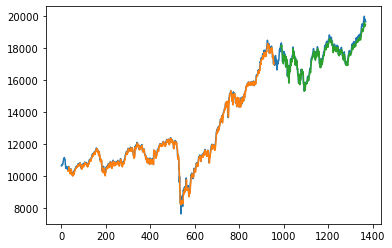

In [19]:
look_back=30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_pred)+look_back, :] = train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pred)+(look_back*2)+1:len(df)-1, :] = test_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [45]:
model.save('C:/Users/Home/Desktop/i_hate_this/StockPricePrediction/artifacts/models/model.h5')
model.save('model.h5')

Hyperparameter Tuning

In [20]:
def build_model(hp):
    model = Sequential()
    model.add(layers.Input((30, 1)),)
    model.add(layers.LSTM(64))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    learning_rate = hp.Choice('learning_rate',  values=[1e-2, 1e-3, 1e-4])

    optimizers = hp.Choice('optimizer', values=['Adagrad', 'Adadelta', 'Adadelta', 'Rmsprop'])

    model.compile(optimizer=Adam(learning_rate=learning_rate), metrics=['mean_squared_error', 'accuracy'], loss='mse')
    
    return model

In [21]:
tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        max_trials = 5,
                        directory='mydir')

In [22]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 09s]
val_loss: 0.0008232906693592668

Best val_loss So Far: 0.0005793613381683826
Total elapsed time: 00h 00m 49s
INFO:tensorflow:Oracle triggered exit


In [23]:
tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.01, 'optimizer': 'Adadelta'}

Training on new parameters after hyperparameter tuning

In [24]:
tuned_model = tuner.get_best_models(num_models=1)[0]

In [25]:
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


In [26]:
tuned_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, initial_epoch=6, epochs=200, shuffle=False, verbose=1)

Epoch 7/200
93/93 [==============================] - 8s 34ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - accuracy: 0.0011 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_accuracy: 0.0026
Epoch 8/200
93/93 [==============================] - 2s 18ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - accuracy: 0.0011 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_accuracy: 0.0026
Epoch 9/200
93/93 [==============================] - 1s 15ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - accuracy: 0.0011 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_accuracy: 0.0026
Epoch 10/200
93/93 [==============================] - 2s 16ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - accuracy: 0.0011 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_accuracy: 0.0026
Epoch 11/200
93/93 [==============================] - 1s 15ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - accuracy: 0.0011 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 -

Epoch 46/200
93/93 [==============================] - 1s 15ms/step - loss: 5.0983e-04 - mean_squared_error: 5.0983e-04 - accuracy: 0.0011 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_accuracy: 0.0026
Epoch 47/200
93/93 [==============================] - 1s 15ms/step - loss: 5.8010e-04 - mean_squared_error: 5.8010e-04 - accuracy: 0.0011 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_accuracy: 0.0026
Epoch 48/200
93/93 [==============================] - 1s 15ms/step - loss: 6.3697e-04 - mean_squared_error: 6.3697e-04 - accuracy: 0.0011 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_accuracy: 0.0026
Epoch 49/200
93/93 [==============================] - 1s 15ms/step - loss: 7.0168e-04 - mean_squared_error: 7.0168e-04 - accuracy: 0.0011 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_accuracy: 0.0026
Epoch 50/200
93/93 [==============================] - 1s 15ms/step - loss: 7.3113e-04 - mean_squared_error: 7.3113e-04 - accuracy: 0.0011 - val_loss

93/93 [==============================] - 1s 12ms/step - loss: 6.4604e-04 - mean_squared_error: 6.4604e-04 - accuracy: 0.0011 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_accuracy: 0.0026
Epoch 85/200
93/93 [==============================] - 1s 12ms/step - loss: 6.5560e-04 - mean_squared_error: 6.5560e-04 - accuracy: 0.0011 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_accuracy: 0.0026
Epoch 86/200
93/93 [==============================] - 1s 12ms/step - loss: 7.4928e-04 - mean_squared_error: 7.4928e-04 - accuracy: 0.0011 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_accuracy: 0.0026
Epoch 87/200
93/93 [==============================] - 1s 13ms/step - loss: 9.3617e-04 - mean_squared_error: 9.3617e-04 - accuracy: 0.0011 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_accuracy: 0.0026
Epoch 88/200
93/93 [==============================] - 1s 12ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - accuracy: 0.0011 - val_loss: 0.0059 - val_mean_s

93/93 [==============================] - 1s 12ms/step - loss: 6.2268e-04 - mean_squared_error: 6.2268e-04 - accuracy: 0.0011 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_accuracy: 0.0026
Epoch 123/200
93/93 [==============================] - 1s 12ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - accuracy: 0.0011 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_accuracy: 0.0026
Epoch 124/200
93/93 [==============================] - 1s 12ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - accuracy: 0.0011 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_accuracy: 0.0026
Epoch 125/200
93/93 [==============================] - 1s 12ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - accuracy: 0.0011 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_accuracy: 0.0026
Epoch 126/200
93/93 [==============================] - 1s 12ms/step - loss: 2.7340e-04 - mean_squared_error: 2.7340e-04 - accuracy: 0.0011 - val_loss: 0.0013 - val_mean_squared_error

Epoch 160/200
93/93 [==============================] - 1s 12ms/step - loss: 5.3557e-04 - mean_squared_error: 5.3557e-04 - accuracy: 0.0011 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_accuracy: 0.0026
Epoch 161/200
93/93 [==============================] - 1s 12ms/step - loss: 6.6601e-04 - mean_squared_error: 6.6601e-04 - accuracy: 0.0011 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_accuracy: 0.0026
Epoch 162/200
93/93 [==============================] - 1s 12ms/step - loss: 4.2239e-04 - mean_squared_error: 4.2239e-04 - accuracy: 0.0011 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_accuracy: 0.0026
Epoch 163/200
93/93 [==============================] - 1s 12ms/step - loss: 3.1599e-04 - mean_squared_error: 3.1599e-04 - accuracy: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_accuracy: 0.0026
Epoch 164/200
93/93 [==============================] - 1s 12ms/step - loss: 3.0885e-04 - mean_squared_error: 3.0885e-04 - accuracy: 0.0011 - val

93/93 [==============================] - 1s 12ms/step - loss: 3.0287e-04 - mean_squared_error: 3.0287e-04 - accuracy: 0.0011 - val_loss: 3.3790e-04 - val_mean_squared_error: 3.3790e-04 - val_accuracy: 0.0026
Epoch 199/200
93/93 [==============================] - 1s 12ms/step - loss: 3.8382e-04 - mean_squared_error: 3.8382e-04 - accuracy: 0.0011 - val_loss: 4.1550e-04 - val_mean_squared_error: 4.1550e-04 - val_accuracy: 0.0026
Epoch 200/200
93/93 [==============================] - 1s 12ms/step - loss: 2.5233e-04 - mean_squared_error: 2.5233e-04 - accuracy: 0.0011 - val_loss: 4.9615e-04 - val_mean_squared_error: 4.9615e-04 - val_accuracy: 0.0026


In [27]:
train_pred = tuned_model.predict(X_train)
test_pred = tuned_model.predict(X_test)

12/12 [==============================] - 0s 6ms/step


In [28]:
trained_pred = scaler.inverse_transform(train_pred)
tested_pred = scaler.inverse_transform(test_pred)

In [29]:
tuned_model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 8ms/step - loss: 4.9615e-04 - mean_squared_error: 4.9615e-04 - accuracy: 0.0026


[0.0004961520317010581, 0.0004961520317010581, 0.002624671906232834]

In [30]:
train_err_val = math.sqrt(mse(y_train, train_pred))
print(train_val)
test_err_val = math.sqrt(mse(y_test, test_pred))
print(test_val)

12452.999163529186
17490.898794651148


Plotting the data

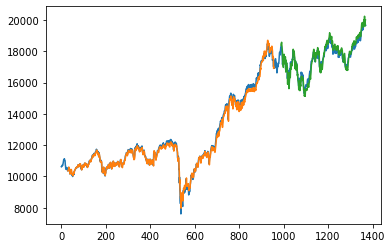

In [31]:
look_back=30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_pred)+look_back, :] = trained_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pred)+(look_back*2)+1:len(df)-1, :] = tested_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Predicting future 10 days and plotting the output

In [32]:
x_input=test_data[-30:].reshape(1,-1)
x_input.shape

(1, 30)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input[:5]

[0.9067701772827738,
 0.9010662926186629,
 0.9060182283660333,
 0.9092643043596141,
 0.902343753084104]

In [34]:
from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<10):
    
    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = tuned_model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = tuned_model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.9783540964126587], [0.9991809129714966], [1.0122261047363281], [1.021923542022705], [1.0312589406967163], [1.0376251935958862], [1.0388591289520264], [1.0351688861846924], [1.028056263923645], [1.0196170806884766]]


In [35]:
day_new=np.arange(1,31)
day_pred=np.arange(31,41)

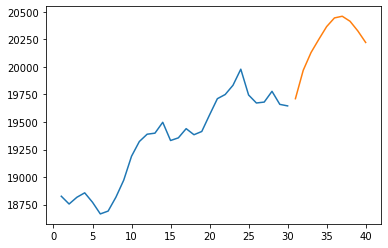

In [36]:
plt.plot(day_new,scaler.inverse_transform(df[(len(df)-30):]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [37]:
new_days = scaler.inverse_transform(lst_output)
new_days

array([[19711.41436529],
       [19969.01918476],
       [20130.37386227],
       [20250.32049811],
       [20365.78911442],
       [20444.53266239],
       [20459.7950859 ],
       [20414.15084069],
       [20326.17552443],
       [20221.79210762]])

In [44]:
tuned_model.save('C:/Users/Home/Desktop/i_hate_this/StockPricePrediction/artifacts/models/tuned_model.h5')
tuned_model.save('tuned_model.h5')